In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import scipy.sparse as sp


import subprocess
import json
import tempfile
from transformers import RobertaTokenizer

from collections import defaultdict

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score
)
from tqdm import tqdm

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
def drop_node(feats, drop_rate,training=True,seed=42):
    """
    Args:
        feats (Tensor): 节点特征 [batch_size, num_nodes, feature_dim] 或 [num_nodes, feature_dim]
        drop_rate (float): 丢弃概率。

    Returns:
        Tensor: 丢弃后的节点特征，与输入形状一致。
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if not training or drop_rate <= 0.0:
        return feats
    if feats.dim() == 2:  # [num_nodes, feature_dim]
        num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((num_nodes,), drop_rate, device=feats.device, dtype=feats.dtype)  # [num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(1).expand(-1, feature_dim)  # [num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    elif feats.dim() == 3:  # [batch_size, num_nodes, feature_dim]
        batch_size, num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((batch_size, num_nodes), drop_rate, device=feats.device, dtype=feats.dtype)  # [batch_size, num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(2).expand(-1, -1, feature_dim)  # [batch_size, num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    else:
        raise ValueError(f"Unsupported feats dimension: {feats.dim()}")

    return feats


class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, input_dropout, hidden_dropout, batchnorm):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(in_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, out_dim)
        self.input_dropout = nn.Dropout(input_dropout)
        self.hidden_dropout = nn.Dropout(hidden_dropout)
        self.bn1 = nn.BatchNorm1d(in_dim) if batchnorm else None
        self.bn2 = nn.BatchNorm1d(hid_dim) if batchnorm else None

    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()

    def forward(self, x):
        if self.bn1:
            x = self.bn1(x)
        x = self.input_dropout(x)
        x = F.relu(self.layer1(x))
        if self.bn2:
            x = self.bn2(x)
        x = self.hidden_dropout(x)
        x = self.layer2(x)
        return x






class GGGNN(nn.Module):
    def __init__(self, feature_dim_size, hidden_size, num_GNN_layers, dropout, act=nn.functional.relu):
        super(GGGNN, self).__init__()
        self.num_GNN_layers = num_GNN_layers
        self.emb_encode = nn.Linear(feature_dim_size, hidden_size)
        self.dropout_encode = nn.Dropout(dropout)
        self.z0 = nn.Linear(hidden_size, hidden_size)
        self.z1 = nn.Linear(hidden_size, hidden_size)
        self.r0 = nn.Linear(hidden_size, hidden_size)
        self.r1 = nn.Linear(hidden_size, hidden_size)
        self.h0 = nn.Linear(hidden_size, hidden_size)
        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.soft_att = nn.Linear(hidden_size, 1)
        self.ln = nn.Linear(hidden_size, hidden_size)
        self.act = act

    def gatedGNN(self, x, adj):
        a = torch.matmul(adj, x)
        # update gate
        z0 = self.z0(a)
        z1 = self.z1(x)
        z = torch.sigmoid(z0 + z1)
        # reset gate
        r = torch.sigmoid(self.r0(a) + self.r1(x))
        # update embeddings
        h = self.act(self.h0(a) + self.h1(r * x))

        return h * z + x * (1 - z)

    def forward(self, inputs, adj, mask):        # mask [B, N]
        x = self.dropout_encode(inputs)
        x = self.emb_encode(x)          # [B, N, H]
        mask_3d = mask.unsqueeze(-1)             # [B, N, 1]

        x = x * mask_3d                          # 广播到 [B, N, H]
        for _ in range(self.num_GNN_layers):
            x = self.gatedGNN(x, adj) * mask_3d  # 避免重复 unsqueeze
        return x

In [3]:
class GRAND_GatedFusion(nn.Module):
    def __init__(self,
                 in_dim,
                 hid_dim,
                 S=5,
                 K=3,
                 num_GNN_layers=2,
                 node_dropout=0.05,
                 input_droprate=0.1,
                 hidden_droprate=0.1,
                 batchnorm=False,
                 att_op='sum',
                 num_heads=8,
                 temp=0.5,
                 lam=1.0,
                 gnn_dropout=0.1,
                 args=None):
        super(GRAND_GatedFusion, self).__init__()
        self.S = S
        self.K = K
        self.args = args
        self.node_dropout_rate = node_dropout
        self.att_op = att_op
        self.temp = temp
        self.lam = lam
        
        # GRAND components
        self.grand_mlp = MLP(in_dim, hid_dim, hid_dim, input_droprate, hidden_droprate, batchnorm)
        
        # Gated GNN components
        self.gggnn = GGGNN(in_dim, hid_dim, num_GNN_layers, gnn_dropout)
        
        # Fusion gate parameters
        self.fusion_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.reset_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.update_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.output_gate = nn.Linear(2 * hid_dim, hid_dim)
        
        # Output layer parameters
        if self.att_op == 'atten':
            self.att_fc = nn.Linear(hid_dim, 1)
            self.out_dim = hid_dim
        elif self.att_op == 'mul_head':
            self.att_fc = nn.Linear(hid_dim, num_heads)
            self.out_dim = hid_dim * num_heads
        elif self.att_op == 'concat':
            self.out_dim = 2 * hid_dim
        else:
            self.out_dim = hid_dim



    
    def normalize_adj(self, adj):
        # if adj.dim() == 3:
        #     adj_norm = []
        #     eye = torch.eye(adj.size(-1), device=adj.device)
        #     adj = adj + eye
        #     for i in range(adj.size(0)):
        #         deg = adj[i].sum(dim=1).clamp(min=1)
        #         deg_inv_sqrt = deg.pow(-0.5)
        #         D_inv_sqrt = torch.diag(deg_inv_sqrt)
        #         adj_norm.append(D_inv_sqrt @ adj[i] @ D_inv_sqrt)
        #     return torch.stack(adj_norm)
        if adj.dim() == 3:            # batched dense
            eye = torch.eye(adj.size(-1), device=adj.device)
            adj = adj + eye           # 加自环
            deg = adj.sum(-1)         # [B,N]
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)   # 避免除零
            # 利用广播而不是显式 diag，加速
            return deg_inv_sqrt.unsqueeze(-1) * adj * deg_inv_sqrt.unsqueeze(-2)

        # elif adj.dim() == 2:
        #     deg = adj.sum(dim=1).clamp(min=1)
        #     deg_inv_sqrt = deg.pow(-0.5)
        #     D_inv_sqrt = torch.diag(deg_inv_sqrt)
        #     return D_inv_sqrt @ adj @ D_inv_sqrt
        elif adj.dim() == 2:
            N = adj.size(0)
            eye = torch.eye(N, device=adj.device, dtype=adj.dtype)
            adj = adj + eye
            deg = adj.sum(dim=1)                      
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)    
            return deg_inv_sqrt.unsqueeze(1) * adj * deg_inv_sqrt.unsqueeze(0)


        else:
            raise ValueError(f"Unsupported adj dimension: {adj.dim()}")

    def grand_conv(self, X, adj_norm):
        X_agg = X.clone()
        for _ in range(self.K):
            X = adj_norm @ X
            X_agg += X
        return X_agg / (self.K + 1)

    def gate_fusion(self, grand_feats, ggnn_feats):
        """Gated fusion mechanism combining GRAND and Gated GNN features"""
        combined = torch.cat([grand_feats, ggnn_feats], dim=-1)
        
        # Gating mechanisms
        reset = torch.sigmoid(self.reset_gate(combined))
        update = torch.sigmoid(self.update_gate(combined))
        
        # Intermediate fusion state
        intermediate = torch.tanh(self.fusion_gate(torch.cat([grand_feats, reset * ggnn_feats], dim=-1)))
        
        # Final fused output
        fused_output = update * ggnn_feats + (1 - update) * intermediate
        
        # Output gate
        output_gate = torch.sigmoid(self.output_gate(combined))
        return output_gate * fused_output + (1 - output_gate) * grand_feats

    def aggregate(self, x, mask=None):
        """Aggregate node features into graph-level embeddings"""
        x_sum = torch.sum(x, dim=1, keepdim=True)
        x_max = torch.amax(x, dim=1, keepdim=True)
        x_mean = torch.mean(x, dim=1, keepdim=True)
        
        if self.att_op == 'sum':
            return (x_sum + x_max).squeeze(1)
        elif self.att_op == 'max+mean':
            return (x_mean + x_max).squeeze(1)
        elif self.att_op == 'concat':
            return torch.cat((x_sum, x_max), dim=2).squeeze(1)
        elif self.att_op == 'atten':            # 单头注意力
            scores = self.att_fc(x).squeeze(-1)         # [B, N]
            if mask is not None:
                scores = scores.masked_fill(mask == 0, -1e9)
            alpha = torch.softmax(scores, dim=1).unsqueeze(-1)
            return (alpha * x).sum(dim=1)
        elif self.att_op == 'mul_head':         # 多头注意力
            scores = self.att_fc(x)                       # [B, N, H]
            if mask is not None:
                scores = scores.masked_fill(mask.unsqueeze(-1) == 0, -1e9)  
            alpha = torch.softmax(scores, dim=1)
            z_heads = (alpha.unsqueeze(-1) * x.unsqueeze(2)).sum(dim=1)
            return z_heads.reshape(x.size(0), -1)
        else:
            # multiply
            return (x_sum * x_max).squeeze(1)

    def forward(self, inputs, adj, mask=None, seed=None):
        inputs = inputs
        adj = adj
        mask = mask if mask is not None else None
        
        # Precompute Gated GNN features (only once)
        ggnn_feats = self.gggnn(inputs, adj, mask) if mask is not None else self.gggnn(inputs, adj, torch.ones_like(inputs[:, :, 0]))
        
        if self.training:
            emb_list = [] 
            enhanced_outputs = []
            adj_norm = self.normalize_adj(adj)
            
            for i in range(self.S):
                # GRAND feature propagation with node dropout
                grand_inputs = drop_node(inputs, self.node_dropout_rate, True, seed=int(int(seed)*10+i))
                grand_prop = torch.stack([self.grand_conv(grand_inputs[b], adj_norm[b]) for b in range(grand_inputs.size(0))])
                
                # Pass through GRAND's MLP
                grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
                grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
                
                # Gated fusion of GRAND and Gated GNN features
                fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
                
                # Apply mask if provided
                if mask is not None:
                    fused_feats = fused_feats * mask.unsqueeze(-1)
                
                # Aggregate to graph-level
                graph_emb = self.aggregate(fused_feats, mask)
                emb_list.append(graph_emb) 
                enhanced_outputs.append(graph_emb)
            
            # Compute consistency loss
            # ps = [torch.softmax(output, dim=-1) for output in enhanced_outputs]
            # avg_p = torch.mean(torch.stack(ps, dim=0), dim=0)
            # sharp_p = (torch.pow(avg_p, 1./self.temp) / 
            #           torch.sum(torch.pow(avg_p, 1./self.temp), dim=-1, keepdim=True)).detach()
            
            # consistency_loss = sum(torch.mean((p - sharp_p).pow(2).sum(dim=-1)) for p in ps) / len(ps)
            
            # Return mean graph embedding and consistency loss
            # return torch.mean(torch.stack(enhanced_outputs, dim=0), dim=0), consistency_loss

            return torch.stack(emb_list, dim=0), None
        
        
        else:  # Inference mode
            # GRAND feature propagation without dropout
            adj_norm = self.normalize_adj(adj)
            grand_prop = torch.stack([self.grand_conv(inputs[b], adj_norm[b]) for b in range(inputs.size(0))])
            
            # Pass through GRAND's MLP
            grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
            grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
            
            # Gated fusion
            fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
            
            # Apply mask if provided
            if mask is not None:
                fused_feats = fused_feats * mask.unsqueeze(-1)
            
            # Aggregate to graph-level
            graph_emb = self.aggregate(fused_feats, mask)
            return graph_emb, None


In [4]:
import torch.nn as nn, torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, base_cfg, num_classes):
        super().__init__()
        self.encoder = GRAND_GatedFusion(**base_cfg).float()
        self.classifier = nn.Linear(self.encoder.out_dim, num_classes)
        # self.classifier = nn.Linear(base_cfg['hid_dim']*base_cfg['num_heads'],  # out_dim
        #                             num_classes)

    def forward(self, x, adj, mask, seed=None, train_consistency=True):
        if self.training and train_consistency:
            # ---------- (1) 取 [S, B, D] ----------
            emb_stack, _ = self.encoder(x, adj, mask, seed=seed)

            # ---------- (2) 得到 [S, B, C] ----------
            logits_stack = self.classifier(emb_stack)

            # ---------- (3) 计算 Sharpen consistency ----------
            ps = torch.softmax(logits_stack, dim=-1)       # [S,B,C]
            avg_p = ps.mean(dim=0)                         # [B,C]

            temp = self.encoder.temp                       # 与 cfg 保持一致
            sharp_p = (avg_p.pow(1. / temp) /
                    avg_p.pow(1. / temp).sum(dim=-1, keepdim=True)).detach()

            consistency = ((ps - sharp_p) ** 2).sum(-1).mean()

            # ---------- (4) 把 S 个 logits 取平均做分类 ----------
            logits = logits_stack.mean(dim=0)              # [B,C]

        else:                                              # Eval 或关闭一致性
            emb, _ = self.encoder(x, adj, mask)
            logits = self.classifier(emb)
            consistency = torch.tensor(0., device=logits.device)

        return logits, consistency


In [5]:

import json, re, os, random


from dataclasses import dataclass
from typing import List
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer,
                          LongformerConfig, LongformerForSequenceClassification, LongformerTokenizer,
                          AutoTokenizer)
# Jupyter Cell 2
def clean_code(code: str) -> str:
    """去单/多行注释 + 空行"""
    code = re.sub(r"//.*?$",     "", code, flags=re.MULTILINE)
    code = re.sub(r"/\*.*?\*/",  "", code, flags=re.DOTALL)
    code = re.sub(r"^\s*$\n?",   "", code, flags=re.MULTILINE)
    return code.strip()

@dataclass
class InputFeatures:
    input_ids:  List[int]
    attention_mask: List[int]
    label: int
    idx: str

# def convert_example(js, tokenizer, block_size):
#     code = ' '.join(clean_code(js['func']).split())
#     tokens = tokenizer.tokenize(code)[: block_size - 2]
#     tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

#     input_ids = tokenizer.convert_tokens_to_ids(tokens)
#     attn_mask = [1] * len(input_ids)

#     pad_len = block_size - len(input_ids)
#     input_ids += [tokenizer.pad_token_id] * pad_len
#     attn_mask += [0] * pad_len

#     return InputFeatures(
#         input_ids      = input_ids,
#         attention_mask = attn_mask,
#         label          = int(js['target']),
#         idx            = str(js['idx'])
#     )
def convert_example(js, tokenizer, block_size):
    code = ' '.join(clean_code(js['func']).split())
    # 只截断，不做padding
    tokens = tokenizer.tokenize(code)[: block_size - 2]
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    attn_mask = [1] * len(input_ids)  # 不再有pad，mask全1

    return InputFeatures(
        input_ids      = input_ids,           # 变长list
        attention_mask = attn_mask,           # 变长list
        label          = int(js['target']),
        idx            = str(js['idx'])
    )
%env http_proxy=http://10.254.25.18:7890
%env https_proxy=http://10.254.25.18:7890

%env TOKENIZERS_PARALLELISM=false


env: http_proxy=http://10.254.25.18:7890
env: https_proxy=http://10.254.25.18:7890
env: TOKENIZERS_PARALLELISM=false


In [6]:
tokenizer =  RobertaTokenizer.from_pretrained('microsoft/graphcodebert-base')


# ('Yutong001/graphcodebert-c-backup')
att_op_dict = {
    'sum': 'sum',
    'mul': 'mul',
    'concat': 'concat'
}



weighted_graph = False
print('using default unweighted graph')

TF_IDF = True
PMI =True

from transformers import RobertaTokenizer  # 确保导入tokenizer
# ('Yutong001/graphcodebert-c-backup')

tokenizer =  RobertaTokenizer.from_pretrained('microsoft/graphcodebert-base')
from collections import Counter

def collect_global_stats(shuffle_doc_words_list, window_size=3):
    token_freq  = Counter()      # P(w)
    pair_freq   = Counter()      # P(w_i, w_j) 共现
    total_windows = 0

    for doc in shuffle_doc_words_list:
        end = len(doc)
        while end > 0 and doc[end-1] in {1, 2}:
            end -= 1
        doc = doc[:end]

        # 更新 token 出现次数
        token_freq.update(doc)

        # 遍历窗口统计共现
        if len(doc) <= window_size:
            windows = [doc]
        else:
            windows = [doc[i:i+window_size] for i in range(len(doc)-window_size+1)]

        for win in windows:
            total_windows += 1
            for i in range(1, len(win)):
                for j in range(0, i):
                    u, v = win[i], win[j]
                    if u == v: 
                        continue
                    pair_freq[(u, v)] += 1
                    pair_freq[(v, u)] += 1   # 无向
    return token_freq, pair_freq, total_windows






def build_graph(shuffle_doc_words_list, word_embeddings, window_size=3, weighted_graph=True,TF_IDF=False, PMI=False):
    if TF_IDF:
        token_freq, pair_freq, W = collect_global_stats(shuffle_doc_words_list, window_size=window_size)
        def pmi(u, v, W, eps=1e-9):
            # 频数 → 概率
            p_uv = pair_freq[(u, v)] / W
            p_u  = token_freq[u] / W
            p_v  = token_freq[v] / W
            val = np.log((p_uv + eps) / (p_u * p_v + eps))
            return max(val, 0.)          # 常见做法：负 PMI 设 0（稀疏化）
        

    x_adj = []
    x_feature = []
    doc_len_list = []
    vocab_set = set()

    # 确保 word_embeddings 是 NumPy 数组
    if isinstance(word_embeddings, torch.Tensor):
        embeddings_np = word_embeddings.cpu().numpy()
    else:
        embeddings_np = word_embeddings

    for i in range(len(shuffle_doc_words_list)):
        doc_words = shuffle_doc_words_list[i]
        end = len(doc_words)
        while end > 0 and doc_words[end-1] in {1, 2}:  # 移除padding
            end -= 1
        doc_words = doc_words[:end]
        doc_len = len(doc_words)

        # 获取token字符串表示
        tokens_str = tokenizer.convert_ids_to_tokens(doc_words)
        
        doc_vocab = list(set(doc_words))
        doc_nodes = len(doc_vocab)

        doc_len_list.append(doc_nodes)
        vocab_set.update(doc_vocab)

        doc_word_id_map = {}
        for j in range(doc_nodes):
            doc_word_id_map[doc_vocab[j]] = j

        # 使用defaultdict简化边计数
        word_pair_count = defaultdict(float)

        # 1. 添加滑动窗口共现边
        windows = []
        if doc_len <= window_size:
            windows.append(doc_words)
        else:
            for j in range(doc_len - window_size + 1):
                window = doc_words[j: j + window_size]
                windows.append(window)

        for window in windows:
            for p in range(1, len(window)):
                for q in range(0, p):
                    word_p_id = window[p]
                    word_q_id = window[q]
                    if word_p_id == word_q_id:
                        continue
                    # 共现边（双向添加）
                    word_pair_count[(word_p_id, word_q_id)] += 1.0
                    word_pair_count[(word_q_id, word_p_id)] += 1.0

        # 2. 添加基本的数据流边（基于常见代码模式）
        for pos in range(1, doc_len):
            current_token = doc_words[pos]
            prev_token = doc_words[pos-1]
            current_token_str = tokens_str[pos]
            
            # 模式1: 赋值语句 (a = b)
            # 处理带空格的等号 (Ġ=) 和普通等号 (=)
            if current_token_str in ["=", "Ġ="] and pos > 0 and pos < doc_len - 1:
                # 连接左侧变量和右侧表达式
                if pos >= 1 and pos < doc_len - 1:
                    left_var = doc_words[pos-1]
                    right_expr = doc_words[pos+1]
                    word_pair_count[(left_var, right_expr)] += 2.0
                    word_pair_count[(right_expr, left_var)] += 2.0
            
            # 模式2: 方法调用 (obj.method())
            # 处理带空格的点 (Ġ.) 和普通点 (.)
            if current_token_str in [".", "Ġ."] and pos > 0 and pos < doc_len - 1:
                # 连接对象和方法名
                if pos >= 1 and pos < doc_len - 1:
                    obj = doc_words[pos-1]
                    method = doc_words[pos+1]
                    word_pair_count[(obj, method)] += 1.5
                    word_pair_count[(method, obj)] += 1.5
            
            # 模式3: 函数参数 (func(a, b))
            # 处理带空格的开括号 (Ġ() 和普通开括号 (()
            if current_token_str in ["(", "Ġ("] and pos > 0:
                # 连接函数名和参数
                func_name = doc_words[pos-1]
                # 添加函数名到下一个token的边
                if pos < doc_len - 1:
                    first_param = doc_words[pos+1]
                    word_pair_count[(func_name, first_param)] += 1.2
                    word_pair_count[(first_param, func_name)] += 1.2
                # 添加函数名到所有后续参数
                param_pos = pos + 1
                # 处理带空格的闭括号 (Ġ)) 和普通闭括号 ())
                while param_pos < doc_len and tokens_str[param_pos] not in [")", "Ġ)"]:
                    if tokens_str[param_pos] not in [",", "Ġ,", ";", "Ġ;"]:
                        param_token = doc_words[param_pos]
                        word_pair_count[(func_name, param_token)] += 0.8
                        word_pair_count[(param_token, func_name)] += 0.8
                    param_pos += 1
            
            # 模式4: 返回值 (return x)
            # 检查带空格的return (Ġreturn) 和普通return (return)
            if tokens_str[pos-1] in ["return", "Ġreturn"] and pos > 1:
                return_value = current_token
                word_pair_count[(prev_token, return_value)] += 1.3
                word_pair_count[(return_value, prev_token)] += 1.3

        # 3. 添加子词连接边（处理长变量名）
        current_var_tokens = []  # 当前变量名的token序列
        
        for pos in range(doc_len):
            token_id = doc_words[pos]
            token_str = tokens_str[pos]
            
            # 检查是否是变量名的开始或延续
            if token_str.startswith("Ġ") or not current_var_tokens:
                # 新token开始（以空格开头或当前序列为空）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        # 添加强连接（双向）
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                
                # 重置当前变量名（跳过特殊token和运算符）
                # 只将标识符加入变量名序列
                if token_str not in ["[CLS]", "[SEP]", "[PAD]", "(", ")", "{", "}", "=", ".", ",", ";"] \
                   and not token_str.startswith("Ġ(") \
                   and not token_str.startswith("Ġ)") \
                   and not token_str.startswith("Ġ{") \
                   and not token_str.startswith("Ġ}") \
                   and not token_str.startswith("Ġ=") \
                   and not token_str.startswith("Ġ.") \
                   and not token_str.startswith("Ġ,") \
                   and not token_str.startswith("Ġ;"):
                    current_var_tokens = [token_id]
                else:
                    current_var_tokens = []
            elif token_str.startswith("##") or token_str.isalnum() or '_' in token_str:
                # 变量名延续（子词token或标识符）
                current_var_tokens.append(token_id)
            else:
                # 其他token（标点、关键字等）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                current_var_tokens = []
        
        # 处理文档末尾的变量名
        if current_var_tokens:
            for idx in range(1, len(current_var_tokens)):
                prev_id = current_var_tokens[idx-1]
                curr_id = current_var_tokens[idx]
                
                word_pair_count[(prev_id, curr_id)] += 3.0
                word_pair_count[(curr_id, prev_id)] += 3.0

        # 构建邻接矩阵
        row, col, weight = [], [], []
        for (u, v), w in word_pair_count.items():
            if u in doc_word_id_map and v in doc_word_id_map:
                row.append(doc_word_id_map[u])
                col.append(doc_word_id_map[v])
                if TF_IDF:
                    weight.append(pmi(u, v, W))
                else:
                    weight.append(w if weighted_graph else 1.0)
        
        adj = sp.csr_matrix((weight, (row, col)), shape=(doc_nodes, doc_nodes))
        x_adj.append(adj)

        # 构建节点特征
        features = []
        for word_id in doc_vocab:
            # 确保 word_id 是整数
            word_id = int(word_id)
            
            # 检查索引是否在嵌入矩阵范围内
            if word_id < embeddings_np.shape[0]:
                features.append(embeddings_np[word_id])
            else:
                # 处理超出范围的索引 - 使用零向量
                features.append(np.zeros(embeddings_np.shape[1]))
        
        x_feature.append(features)

    return x_adj, x_feature

class JsonlCodeDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=512, sample_percent=1.0):
        self.features = []
        with open(file_path) as f:
            total = sum(1 for _ in f)
        with open(file_path) as f:
            for line in tqdm(f, total=total, desc="Building dataset"):
                js = json.loads(line)
                feat = convert_example(js, tokenizer, block_size)
                self.features.append(feat)

        # 采样（可选）
        if 0 < sample_percent < 1.0:
            random.seed(42)
            random.shuffle(self.features)
            keep_num = int(sample_percent * len(self.features))
            self.features = self.features[:keep_num]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feat = self.features[idx]
        # 直接返回python list，保留变长
        return (
            feat.input_ids,        # list[int]
            feat.attention_mask,   # list[int]（虽然后面用不到也保留）
            int(feat.label),       # int
        )
    
model = RobertaForSequenceClassification.from_pretrained('microsoft/graphcodebert-base').to('cpu')
w_embeddings = model.get_input_embeddings().weight.data.cpu().detach().clone().numpy()


# -----------------------
# 2) collate：对每个样本生成若干 chunk 的 adj/feat 列表
# -----------------------
def collate_graph_split_chunks(batch, window_size=3, chunk_size=512, weighted_graph=True, TF_IDF=True):
    """
    batch: List[ (input_ids(list[int]), attn_mask(list[int]), label(int)) ]
    """
    ids, masks, labels = zip(*batch)              # 现在 ids 是 List[List[int]]
    labels = torch.tensor(labels, dtype=torch.long)

    all_adjs, all_feats, chunks_per_sample = [], [], []

    for doc_ids in ids:
        # 这里不再依赖 padding 长度；只按有效 token 切分
        chunks = split_into_chunks(
            doc_ids,
            chunk_size=chunk_size,
            pad_id=tokenizer.pad_token_id,
            cls_id=tokenizer.cls_token_id,
            sep_id=tokenizer.sep_token_id
        )
        sample_adjs, sample_feats = [], []

        for chunk in chunks:
            x_adj, x_feat = build_graph(
                shuffle_doc_words_list=[chunk],
                word_embeddings=w_embeddings,
                window_size=window_size,
                weighted_graph=weighted_graph,
                TF_IDF=TF_IDF,
                PMI=PMI
            )
            sample_adjs.append(x_adj[0])
            sample_feats.append(x_feat[0])

        all_adjs.append(sample_adjs)
        all_feats.append(sample_feats)
        chunks_per_sample.append(len(chunks))

    return {
        # 这两个原本没被下游用到，就不返回stack后的Tensor了，避免变长问题
        # "input_ids": ids,
        # "attention_mask": masks,
        "labels": labels,
        "adjs": all_adjs,
        "feats": all_feats,
        "chunks_per_sample": chunks_per_sample
    }


# -----------------------
# 1) 切分 util
# -----------------------
def split_into_chunks(id_list, chunk_size=512, pad_id=None, cls_id=None, sep_id=None):
    """
    只从有效token切分：
      - 去掉首个 [CLS]（如果存在）
      - 去掉末尾的 [SEP]（如果存在）
      - 去掉所有 [PAD]
    最后再按 chunk_size 均匀切分（不够则右侧pad为 pad_id）
    """
    # 缺省从 tokenizer 获取
    if pad_id is None: pad_id = tokenizer.pad_token_id
    if cls_id is None: cls_id = tokenizer.cls_token_id
    if sep_id is None: sep_id = tokenizer.sep_token_id

    ids = list(id_list)

    # 1) 去掉首个 [CLS]
    if len(ids) > 0 and ids[0] == cls_id:
        ids = ids[1:]

    # 2) 去掉末尾 [SEP]
    if len(ids) > 0 and ids[-1] == sep_id:
        ids = ids[:-1]

    # 3) 删除所有 [PAD]（通常只在末尾，但这里更稳健）
    ids = [t for t in ids if t != pad_id]

    # 4) 空样本兜底：返回一个全pad chunk，避免出现空图
    if len(ids) == 0:
        return [[pad_id] * chunk_size]

    # 5) 定长切分，不把pad当切分依据
    chunks = []
    for i in range(0, len(ids), chunk_size):
        chunk = ids[i:i+chunk_size]
        if len(chunk) < chunk_size:
            chunk = chunk + [pad_id] * (chunk_size - len(chunk))
        chunks.append(chunk)
    return chunks



# -----------------------
# 3) flatten: 把 batch 的 chunks 拉平成单一 batch，并返回映射 sample->chunk ranges
# -----------------------
def batch_chunks_to_tensor(batch, device):
    """
    输入 batch（来自 collate_graph_split_chunks）
    返回:
      featb_flat: Tensor [B_chunks, N_max, D]
      adjb_flat:  Tensor [B_chunks, N_max, N_max]
      maskb_flat: Tensor [B_chunks, N_max]
      labels_flat: Tensor [B_chunks]           # 每个 chunk 对应的 label（训练时复制，推理时仍用原样本标签）
      sample2chunk_ranges: list of tuples (start_idx, end_idx) for each original sample
    """
    all_adjs = batch["adjs"]    # list length B, each is list of csr
    all_feats = batch["feats"]  # same shape
    labels = batch["labels"].to(device)
    B = len(all_adjs)

    # flatten
    flat_adjs = []
    flat_feats = []
    labels_flat = []
    sample2chunk_ranges = []
    cur = 0
    for i in range(B):
        chunks_adjs = all_adjs[i]
        chunks_feats = all_feats[i]
        k = len(chunks_adjs)
        start = cur
        for j in range(k):
            flat_adjs.append(chunks_adjs[j])
            flat_feats.append(chunks_feats[j])
            labels_flat.append(labels[i].item())
            cur += 1
        end = cur
        sample2chunk_ranges.append((start, end))

    # convert to tensors (pad node count)
    N_max = max(adj.shape[0] for adj in flat_adjs)
    D = len(flat_feats[0][0])
    B_chunks = len(flat_adjs)

    featb = torch.zeros(B_chunks, N_max, D, dtype=torch.float32, device=device)
    adjb  = torch.zeros(B_chunks, N_max, N_max, dtype=torch.float32, device=device)
    maskb = torch.zeros(B_chunks, N_max, dtype=torch.float32, device=device)

    for i, (adj, feat) in enumerate(zip(flat_adjs, flat_feats)):
        n = adj.shape[0]
        adjb[i, :n, :n] = torch.from_numpy(adj.toarray()).to(device)
        featb[i, :n, :]  = torch.from_numpy(np.asarray(feat)).to(device)
        maskb[i, :n]     = 1.

    labels_flat = torch.tensor(labels_flat, dtype=torch.long, device=device)
    return featb, adjb, maskb, labels_flat, sample2chunk_ranges



# （我把它写成按 sample 聚合取 max prob 的 OR 规则）：
@torch.no_grad()
def collect_logits_per_sample(model, dataloader, device='cpu', max_samples=None, chunk_collate=True):
    """
    返回样本级 logits/probs 与 labels
    若 dataloader 使用 collate_graph_split_chunks，则 batch['adjs'] 等为 list[list]
    """
    model.eval()
    sample_preds = []
    sample_probs = []
    sample_labels = []
    seen = 0

    for batch in dataloader:
        # 把 batch 的 chunk flatten
        featb, adjb, maskb, labels_flat, sample2chunk_ranges = batch_chunks_to_tensor(batch, device)
        # 对所有 chunk 一次前向
        logits_chunks, _ = model(featb, adjb, maskb, train_consistency=False)   # [B_chunks, C]
        probs_chunks = torch.softmax(logits_chunks, dim=-1)[:, 1].detach().cpu().numpy()  # positive prob

        # 对每个原样本聚合（OR 规则：任一 chunk prob > 0.5 则正类）
        for (s,e), sample_label in zip(sample2chunk_ranges, batch["labels"].numpy()):
            chunk_probs = probs_chunks[s:e]
            if len(chunk_probs) == 0:
                sample_prob = 0.0
                sample_pred = 0
            else:
                sample_prob = float(np.max(chunk_probs))   # OR: use max prob
                sample_pred = int(sample_prob > 0.5)       # threshold 可改为 argmax 行为
            sample_probs.append(sample_prob)
            sample_preds.append(sample_pred)
            sample_labels.append(int(sample_label))
            seen += 1
            if max_samples is not None and seen >= max_samples:
                break
        if max_samples is not None and seen >= max_samples:
            break

    return np.array(sample_preds), np.array(sample_probs), np.array(sample_labels)





using default unweighted graph


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import os, random, numpy as np, torch
seed_number=42
def set_global_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)        # Python 层哈希随机
    random.seed(seed)                               # 内置 random
    np.random.seed(seed)                            # numpy
    torch.manual_seed(seed)                         # CPU
    torch.cuda.manual_seed(seed)                    # 当前 GPU
    torch.cuda.manual_seed_all(seed)                # 所有 GPU

    # 额外：在部分算子中强制使用确定性实现
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False          # 禁止自动算法搜索
    torch.use_deterministic_algorithms(True)        # ≥1.8，捕获非确定性算子

    # CUDA ≥ 10.2：卷积类算子还需要这个环境变量
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

set_global_seed(seed_number)

def seed_worker(worker_id):
    # 每个 worker 用不同 seed，但与主进程严格可重复
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_number)

In [8]:

MODEL_NAME = ('microsoft/graphcodebert-base')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ---------- 配置区（修改） ----------
BLOCK_SIZE = 2048            # 训练/验证最大 token（2k）
TEST_BLOCK_SIZE = 8192       # 测试时的 block_size（设大一点以避免被 convert_example 截断）
BATCH_SIZE = 128

# 把 filter_by_len 改为 <=（允许正好等于 max_len 的样本）
def filter_by_len(dataset, max_len=512):
    filtered = []
    for feat in dataset.features:
        real_len = sum(feat.attention_mask)
        if real_len <= max_len:      # <= 而不是 <
            filtered.append(feat)
    dataset.features = filtered
    return dataset


train_ds = JsonlCodeDataset("dataset/train.jsonl", tokenizer, block_size=BLOCK_SIZE)
val_ds  = JsonlCodeDataset("dataset/valid.jsonl", tokenizer, block_size=BLOCK_SIZE)
test_ds  = JsonlCodeDataset("dataset/test.jsonl", tokenizer, block_size=1024*39)



train_ds = filter_by_len(train_ds, max_len=2047)
val_ds   = filter_by_len(val_ds, max_len=2047)
test_ds  = filter_by_len(test_ds, 1024*39)




train_loader = DataLoader(
    train_ds,
    sampler = RandomSampler(train_ds, generator=g),
    batch_size = BATCH_SIZE,
    collate_fn = lambda batch: collate_graph_split_chunks(batch, window_size=3, chunk_size=2048,
                                                          weighted_graph=True, TF_IDF=True),
    num_workers = 32,
    pin_memory = True,
    persistent_workers=True,
    worker_init_fn = seed_worker
)

val_loader = DataLoader(
    val_ds,
    sampler = RandomSampler(val_ds, replacement=False),
    batch_size = BATCH_SIZE,
    collate_fn = lambda batch: collate_graph_split_chunks(batch, window_size=3, chunk_size=2048,
                                                          weighted_graph=True, TF_IDF=True),
    num_workers = 8,
    pin_memory = True,
    persistent_workers=True,
    prefetch_factor=4,
    worker_init_fn = seed_worker
)

test_loader = DataLoader(
    test_ds,
    sampler = RandomSampler(test_ds, replacement=False),
    batch_size = BATCH_SIZE,
    collate_fn = lambda batch: collate_graph_split_chunks(batch, window_size=3, chunk_size=2048,
                                                          weighted_graph=True, TF_IDF=True),
    num_workers = 8,
    pin_memory = True,
    worker_init_fn = seed_worker
)
# 38s



Building dataset: 100%|██████████| 2732/2732 [00:03<00:00, 772.54it/s]


In [9]:
# 检查脚本：检验 train/val/test 是否在 convert 或 collate 阶段被切片
import numpy as np
from collections import Counter
import itertools
import math
import torch

# 配置（与你训练时一致）
CHUNK_SIZE = 2048   # collate_graph_split_chunks 使用的 chunk_size
BLOCK_SIZE = 2048   # 你为 train/val 设定的 block_size
TEST_BLOCK_SIZE = 8192  # 你为 test 设定的 block_size（脚本中可能不一致）

# helper: 计算 dataset 中每个样本的真实 token 长度（基于 attention_mask）
def dataset_length_stats(ds, topk=5):
    lengths = []
    for feat in ds.features:
        lm = sum(feat.attention_mask) if hasattr(feat, "attention_mask") or isinstance(feat.attention_mask, (list,tuple)) else sum(feat.attention_mask)
        lengths.append(int(lm))
    arr = np.array(lengths, dtype=int)
    return {
        "n_samples": len(arr),
        "min": int(arr.min()) if arr.size>0 else 0,
        "max": int(arr.max()) if arr.size>0 else 0,
        "mean": float(arr.mean()) if arr.size>0 else 0.0,
        "pct_gt_BLOCK": int((arr > BLOCK_SIZE).sum()),
        "pct_gt_CHUNK": int((arr > CHUNK_SIZE).sum()),
        "top5_lengths": sorted(arr, reverse=True)[:topk] if arr.size>0 else []
    }

# helper: inspect one batch from a dataloader (batch is already collated)
def inspect_loader_batch(loader, device='cpu', n_batches=1):
    it = iter(loader)
    info = {"batches_checked":0, "chunks_per_sample_vals": Counter(), "max_chunks_in_batch":0, "avg_chunks_per_sample": None}
    total_chunks_counts = []
    for _ in range(n_batches):
        try:
            batch = next(it)
        except StopIteration:
            break
        # batch 应按你的 collate 返回 dict with "chunks_per_sample"
        cps = batch.get("chunks_per_sample", None)
        if cps is None:
            # 有些 collate 可能返回 different key layout -> try to infer from adjs
            adjs = batch.get("adjs", None)
            if adjs is not None:
                # adjs: list (B) of list (chunks)
                cps = [len(x) for x in adjs]
        if cps is None:
            info["note"] = "无法找到 chunks_per_sample，也无法从 adjs 推断。collate_fn 返回结构未知。"
            break
        # record stats
        for v in cps:
            info["chunks_per_sample_vals"][v] += 1
            total_chunks_counts.append(v)
        info["batches_checked"] += 1
        info["max_chunks_in_batch"] = max(info["max_chunks_in_batch"], max(cps))
    if total_chunks_counts:
        info["avg_chunks_per_sample"] = float(np.mean(total_chunks_counts))
    return info

# ---- run checks ----
print("== dataset length stats ==")
for name, ds in [("train", train_ds), ("val", val_ds), ("test", test_ds)]:
    stats = dataset_length_stats(ds)
    print(f"[{name}] samples={stats['n_samples']}, min={stats['min']}, max={stats['max']}, mean={stats['mean']:.1f}, "
          f">BLOCK({BLOCK_SIZE})={stats['pct_gt_BLOCK']}, >CHUNK({CHUNK_SIZE})={stats['pct_gt_CHUNK']}, top5={stats['top5_lengths']}")






== dataset length stats ==
[train] samples=20866, min=12, max=2046, mean=408.6, >BLOCK(2048)=0, >CHUNK(2048)=0, top5=[2046, 2046, 2046, 2045, 2045]
[val] samples=2597, min=16, max=2046, mean=402.8, >BLOCK(2048)=0, >CHUNK(2048)=0, top5=[2046, 2040, 2028, 2023, 2010]
[test] samples=2732, min=11, max=38735, mean=579.8, >BLOCK(2048)=115, >CHUNK(2048)=115, top5=[38735, 27602, 18619, 15554, 12509]


In [10]:


import math, time, random

from torch.optim.lr_scheduler import CosineAnnealingLR

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'


def evaluate_sample_level(model, dataloader, device='cpu'):
    preds, probs, labels = collect_logits_per_sample(model, dataloader, device=device)
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(labels, probs)
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# 先放在训练循环外，定义一次
import torch.nn.functional as F

def mil_noisyor_bag_loss(logits_chunks, sample2chunk_ranges, labels_per_sample, eps=1e-7):
    probs_pos = torch.softmax(logits_chunks, dim=-1)[:, 1]  # [B_chunks]
    bag_probs = []
    for (s, e) in sample2chunk_ranges:
        p = probs_pos[s:e]
        bag_p = 1.0 - torch.clamp(1.0 - p, min=0.0, max=1.0).prod()
        bag_probs.append(bag_p)
    bag_probs = torch.stack(bag_probs, dim=0)               # [B_samples]
    labels = labels_per_sample.float().to(bag_probs.device)
    bag_probs = torch.clamp(bag_probs, eps, 1 - eps)
    return F.binary_cross_entropy(bag_probs, labels)


config = {
    'in_dim'       : 768,
    'hid_dim'      : 128,     #      64 128 256 
    'S'            : 5,       #      2 3 4
    'K'            : 2,       #       2 4 6
    'num_GNN_layers': 2,     
    'node_dropout' : 0.2,     #      0.1 0.3 0.5 0.7
    'input_droprate': 0.3,
    'hidden_droprate': 0.3,
    'batchnorm'    : True,
    'att_op'       : 'mul_head',
    'num_heads'    : 6,
    'temp'         : 0.6,          
    'lam'          : 1.4,          # 0.8 1.0 1.4 1.6 2.0
    'gnn_dropout'  : 0.2, 
}



num_classes = 2
lam = config['lam']

model_path= "best_model-devign-1-cut512-all.pt"
# 1. 实例化网络（只一次）
net = Net(config, num_classes).to(device)
criterion_cls = nn.CrossEntropyLoss()
# 2. 绑定优化器 / 调度器

optimizer = AdamW(net.parameters(), lr=5e-4, weight_decay=1e-2,no_deprecation_warning=True )

scheduler = CosineAnnealingLR(optimizer, T_max=50)

# 3. 训练循环
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc, best_state, patience, wait = 0.6, None, 20, 0
epochs = 180
best_f1 = 0.57


asdasdas

train_losses, val_losses = [], []
train_accs, val_accs = [], []
wait = 0
init_seed=2345
epoch = 0
while True:
    epoch+=1

    # ===== Train =====
    net.train()
    tr_loss_sum, cons_loss_sum, tr_correct, tr_ex = 0.0, 0.0, 0, 0
    bar = tqdm(train_loader, desc=f"Train Ep{epoch:03d}", leave=False)

    for batch in bar:
    # flatten chunks -> (B_chunks, N_max, D), labels_flat 对应每个 chunk
        featb, adjb, maskb, labels_flat, sample2chunk_ranges = batch_chunks_to_tensor(batch, device)
        bs = labels_flat.size(0)    # 注意：现在 bs 表示 chunk 数量（实际模型前向样本数）
        optimizer.zero_grad()
        seed   = init_seed + epoch

        # logits, cons = net(featb, adjb, maskb, seed=seed, train_consistency=True)
        # cls_loss = criterion_cls(logits, labels_flat)   # 每个 chunk 当独立样本训练

        # loss = cls_loss + lam * cons

        logits, cons = net(featb, adjb, maskb, seed=seed, train_consistency=True)
        cls_loss = mil_noisyor_bag_loss(logits, sample2chunk_ranges, batch["labels"])
        loss = cls_loss + lam * cons

        loss.backward()
        optimizer.step()

        tr_loss_sum += cls_loss.item() * bs
        cons_loss_sum += cons.item() * bs
        tr_correct  += (logits.argmax(1) == labels_flat).sum().item()
        tr_ex       += bs
        bar.set_postfix(cls_loss=f"{cls_loss.item() / max(bs,1):.4f}", cons_loss=f"{cons.item() / max(bs,1):.4f}")


    scheduler.step()
    train_loss = tr_loss_sum / tr_ex
    train_cons_loss = cons_loss_sum / tr_ex
    train_acc  = tr_correct  / tr_ex


    # ===== Validate =====
    net.eval()
    val_loss_sum, val_ex = 0.0, 0  # val_ex 统计“样本（bag）数”，不是 chunk 数

    with torch.no_grad():
        bar = tqdm(val_loader, desc=f"Val Ep{epoch:03d}", leave=False)
        for batch in bar:
            # 展平本 batch 的所有 chunk
            featb, adjb, maskb, labels_flat, sample2chunk_ranges = batch_chunks_to_tensor(batch, device)
            # 前向（验证时不做一致性）
            logits, _ = net(featb, adjb, maskb, train_consistency=False)

            # —— 用 MIL 的 bag-level 验证损失 —— #
            labels_per_sample = batch["labels"].to(device)   # [B_samples]
            batch_bag_loss = mil_noisyor_bag_loss(logits, sample2chunk_ranges, labels_per_sample)

            # 以“样本数”做加权累计
            b_samples = len(sample2chunk_ranges)
            val_loss_sum += batch_bag_loss.item() * b_samples
            val_ex       += b_samples

    # bag-level 验证损失（与训练目标一致）
    val_loss = val_loss_sum / max(val_ex, 1)

    # —— 样本级指标（保持不变，仍用 OR 聚合/你的 evaluate_sample_level）——
    val_acc_s, prec_s, rec_s, f1_s, auc_s = evaluate_sample_level(net, val_loader, device=device)

    # 记录并打印（用样本级指标作为真实验证信号）
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc_s)   # 注意这里换成样本级 acc

    tqdm.write(
        f"Epoch {epoch:03d} | "
        f"train_loss {train_loss:.4f} (cls) + {train_cons_loss:.4f} (cons)  "
        f"triain_acc {train_acc:.4f} | "
        f"val_loss {val_loss:.4f} acc {val_acc_s:.4f} | "
        f"P {prec_s:.4f} R {rec_s:.4f} F1 {f1_s:.4f}"
    )

    # ===== Early-stopping =====

    if val_acc_s > best_val_acc:
        best_f1 = f1_s
        best_val_acc = val_acc_s
        best_state = net.state_dict()
        torch.save(net.state_dict(), model_path)
        tqdm.write(f"💾 Saved new best ckpt: acc={best_val_acc:.4f} @ epoch {epoch:03d}")
        wait = 0
    elif val_acc_s == best_val_acc:
        if f1_s > best_f1:
            best_f1= f1_s
            best_state = net.state_dict()
            torch.save(net.state_dict(), model_path)
            tqdm.write(f"💾 Saved better ckpt by F1: acc={best_val_acc:.4f} F1={best_f1:.4f} @ epoch {epoch:03d}")
    else:
        wait += 1
        if wait >= patience:
            tqdm.write(f"Early stop at epoch {epoch}")
            break




NameError: name 'asdasdas' is not defined

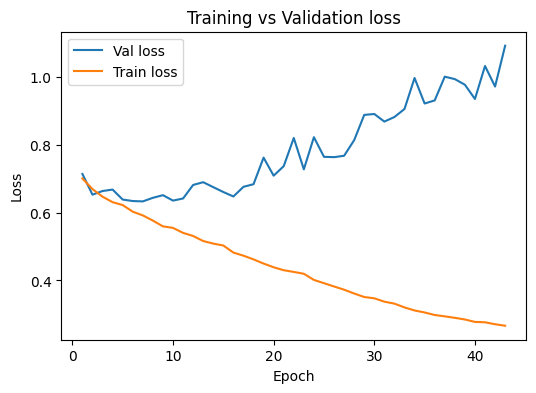

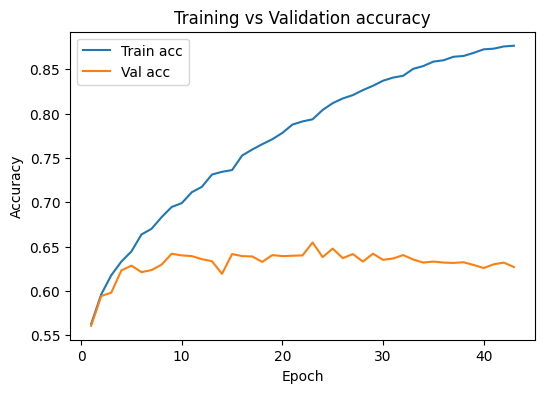

In [12]:
import matplotlib.pyplot as plt

epochs_r = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
def to_float(x):
    if torch.is_tensor(x):
        return x.detach().cpu().item()
    return float(x)

val_vals   = [to_float(v) for v in val_losses]
train_vals = [to_float(v) for v in train_losses]

plt.plot(epochs_r, val_vals,   label='Val loss')
plt.plot(epochs_r, train_vals, label='Train loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation loss')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_r, train_accs, label='Train acc')
plt.plot(epochs_r, val_accs,  label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation accuracy')
plt.show()


In [11]:
# # === 重新实例化网络，与训练时配置保持一致 ===
best_net = Net(config, num_classes).to(device)

# # === 加载参数 ===
best_net.load_state_dict(torch.load(model_path, map_location=device,weights_only=False))

# best_net=copy.deepcopy(best_model)
best_net.eval()      # 切到推理模式




def pretty_print(split_name, metrics):
    acc, prec, rec, f1, auc= metrics
    print(
        f"{split_name:<5} | "
        f"acc {acc:6.4f} | "
        f"P {prec:6.4f} | "
        f"R {rec:6.4f} | "
        f"F1 {f1:6.4f}| "
        f"AUC {auc:6.4f}"
    )




# 评估
val_metrics  = evaluate_sample_level(best_net, val_loader, device=device)
test_metrics = evaluate_sample_level(best_net, test_loader,  device=device)

# 打印
print("="*55)
pretty_print("VAL",  val_metrics)
pretty_print("TEST", test_metrics)
print("="*55)
# =======================================================
# VAL   | loss   0.0195 | acc 0.6546 | P 0.6041 | R 0.6025 | F1 0.6033| AUC 0.7135
# TEST  | loss   0.0195 | acc 0.6321 | P 0.5901 | R 0.6526 | F1 0.6198| AUC 0.6973
# =======================================================

VAL   | acc 0.6546 | P 0.6041 | R 0.6025 | F1 0.6033| AUC 0.7135
TEST  | acc 0.6307 | P 0.5972 | R 0.6024 | F1 0.5998| AUC 0.6994


In [12]:
# # === 重新实例化网络，与训练时配置保持一致 ===
best_net = Net(config, num_classes).to(device)

# # === 加载参数 ===
best_net.load_state_dict(torch.load(model_path, map_location=device,weights_only=False))

# best_net=copy.deepcopy(best_model)
best_net.eval()      # 切到推理模式


length_bins = {
    "(0-512]"     : (1,   512),
    "(512-1k]"    : (513, 1023),
    "(1k-2k]"   : (1024,2048),
    "(2k-8k]"     : (2049,8191),
    "(8k-inf]"    : (8192,99999999),
}
def get_sample_lengths(dataset):
    lengths = []
    for feat in dataset.features:
        real_len = sum(feat.attention_mask)
        lengths.append(real_len)
    return lengths
from torch.utils.data import Subset

def evaluate_by_length_bins(model, dataset, dataloader_fn, length_bins,):
    lengths = get_sample_lengths(dataset)
    results = {}
    for name, (lo, hi) in length_bins.items():
        idxs = [i for i, L in enumerate(lengths) if lo <= L <= hi]
        if not idxs:
            continue
        subset = Subset(dataset, idxs)
        loader = DataLoader(
            subset,
            batch_size=BATCH_SIZE,
            collate_fn=lambda batch: collate_graph_split_chunks(
                batch, window_size=3, chunk_size=2048, weighted_graph=True, TF_IDF=True
            ),
            num_workers=8,
            pin_memory=True
        )
        metrics = evaluate_sample_level(model, loader, device=device)
        results[name] = (len(idxs), metrics)
    return results

results = evaluate_by_length_bins(best_net, test_ds, collate_graph_split_chunks, length_bins)

for name, (n, (acc, prec, rec, f1, auc)) in results.items():
    print(f"{name:10} 样本 {n:4d} | "
          f"ACC {acc*100:6.2f}% | P {prec*100:6.2f}% | R {rec*100:6.2f}% | "
          f"F1 {f1*100:6.2f}% | AUC {auc:.4f}")


(0-512]    样本 1860 | ACC  67.53% | P  64.95% | R  60.29% | F1  62.53% | AUC 0.7462
(512-1k]   样本  501 | ACC  53.69% | P  53.96% | R  56.52% | F1  55.21% | AUC 0.5855
(1k-2k]    样本  256 | ACC  55.86% | P  52.00% | R  65.55% | F1  57.99% | AUC 0.5739
(2k-8k]    样本  110 | ACC  49.09% | P  42.47% | R  68.89% | F1  52.54% | AUC 0.5716
(8k-inf]   样本    5 | ACC  20.00% | P   0.00% | R   0.00% | F1   0.00% | AUC 0.0000


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
def evaluate_sample_level_with_confmat(model, dataloader, device="cpu"):
    preds, probs, labels = collect_logits_per_sample(model, dataloader, device=device)
    acc  = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(labels, probs)
    except:
        auc = 0.0
    # 混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, preds, labels=[0,1]).ravel()
    return acc, prec, rec, f1, auc, tp, tn, fp, fn
def evaluate_by_length_bins(model, dataset, length_bins):
    lengths = get_sample_lengths(dataset)
    results = {}
    for name, (lo, hi) in length_bins.items():
        idxs = [i for i, L in enumerate(lengths) if lo <= L <= hi]
        if not idxs:
            continue
        subset = Subset(dataset, idxs)
        loader = DataLoader(
            subset,
            batch_size=BATCH_SIZE,
            collate_fn=lambda batch: collate_graph_split_chunks(
                batch, window_size=3, chunk_size=2048, weighted_graph=True, TF_IDF=True
            ),
            num_workers=8,
            pin_memory=True
        )
        metrics = evaluate_sample_level_with_confmat(model, loader, device=device)
        results[name] = (len(idxs), metrics)
    return results
results = evaluate_by_length_bins(best_net, test_ds, length_bins)

for name, (n, (acc, prec, rec, f1, auc, tp, tn, fp, fn)) in results.items():
    print(f"{name:10} 样本 {n:4d} | "
          f"TP {tp:4d} TN {tn:4d} FP {fp:4d} FN {fn:4d} | "
          f"ACC {acc*100:6.2f}% | P {prec*100:6.2f}% | "
          f"R {rec*100:6.2f}% | F1 {f1*100:6.2f}% | AUC {auc:.4f}")


(0-512]    样本 1860 | TP  504 TN  752 FP  272 FN  332 | ACC  67.53% | P  64.95% | R  60.29% | F1  62.53% | AUC 0.7462
(512-1k]   样本  501 | TP  178 TN  106 FP  142 FN   75 | ACC  56.69% | P  55.62% | R  70.36% | F1  62.13% | AUC 0.5948
(1k-2k]    样本  256 | TP   98 TN   41 FP   96 FN   21 | ACC  54.30% | P  50.52% | R  82.35% | F1  62.62% | AUC 0.5784
(2k-4k]    样本   86 | TP   30 TN    6 FP   43 FN    7 | ACC  41.86% | P  41.10% | R  81.08% | F1  54.55% | AUC 0.5141
(4k-8k]    样本   24 | TP    7 TN    3 FP   13 FN    1 | ACC  41.67% | P  35.00% | R  87.50% | F1  50.00% | AUC 0.6250
(8k-inf]   样本    5 | TP    2 TN    0 FP    3 FN    0 | ACC  40.00% | P  40.00% | R 100.00% | F1  57.14% | AUC 0.5000
